# CartPole 환경에서 SARSA와 Q-Learning을 통해 최적의 Policy 찾기 

CartPole openai gym: https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py  

Agnet는 막대를 세우기 위해 왼쪽, 오른쪽으로 움직인다. Observation으로는 BOX형태의 data가 주어지며 아래와 같다.  

Type: Box(4)  

|Num|Observation|Min| Max|  
|------|---|---|---|
|0|Cart Position|-4.8|4.8|  
|1|Cart Velocity|-Inf|Inf|  
|2|Pole Angle|-0.418 rad (-24 deg)|0.418 rad (24 deg)|  
|3|Pole Angular Velocity|-Inf| Inf|  

reward, episode termination 추가

## Library Import

In [1]:
import gym
import numpy as np
import random
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt

## Env 살펴보기

In [2]:
env = gym.make('CartPole-v1')

for i in range(10):
    state = env.reset()
    done = False
    for t in range(50):
        time.sleep(1/50)
        env.render()
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        #if done:
        #    break

env.close()

C:\Users\shyram\anaconda3\lib\site-packages\gym\envs\classic_control\cartpole.py:150: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  logger.warn(


## Discretize state

**FrozenLake과 다르게 state가 continuous하다. SARSA와 Q-Learning에서는 Q를 state와 action을 통해 정의하기 때문에 CartPole환경에서의 continuous state을 discrete state로 바꿀 수 있어야 한다.**

|Num|Observation|Min| Max|  
|------|---|---|---|
|0|Cart Position|-4.8|4.8|  
|1|Cart Velocity|-Inf|Inf|  
|2|Pole Angle|-0.418 rad (-24 deg)|0.418 rad (24 deg)|  
|3|Pole Angular Velocity|-Inf| Inf|  


observation_space로 continuous state의 범위를 알 수 있다.

In [3]:
env = gym.make('CartPole-v1')

env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [4]:
print(env.observation_space.high)
print(env.observation_space.low)

[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]


`Cart Position`과 `Pole Angle`의 경우 어느정도 정해진 범위가 있으나, `Cart Velocity`, `Pole Angular Velocity`의 경우 너무 넓은 범위를 가지고 있어 어느 범위까지 이산화 해야 하는지 고민이 생긴다.

In [5]:
env.reset()

for t in range(50):
    time.sleep(1/10)
    env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    print(state)
env.close()

[ 0.00679664  0.15712276  0.02898159 -0.25822496]
[ 0.00993909  0.35181922  0.02381708 -0.54162765]
[ 0.01697548  0.5465985   0.01298453 -0.8267121 ]
[ 0.02790745  0.7415405  -0.00354971 -1.1152831 ]
[ 0.04273826  0.5464653  -0.02585537 -0.8237158 ]
[ 0.05366756  0.35170642 -0.04232969 -0.5392757 ]
[ 0.06070169  0.15720427 -0.0531152  -0.2602251 ]
[ 0.06384578  0.35304266 -0.0583197  -0.56917685]
[ 0.07090662  0.54893196 -0.06970324 -0.8796476 ]
[ 0.08188527  0.7449282  -0.0872962  -1.1934042 ]
[ 0.09678383  0.55103856 -0.11116428 -0.92930967]
[ 0.1078046   0.3575785  -0.12975048 -0.6735258 ]
[ 0.11495617  0.16447581 -0.14322099 -0.42434624]
[ 0.11824569  0.36130533 -0.1517079  -0.75853074]
[ 0.1254718   0.16856311 -0.16687852 -0.51716936]
[ 0.12884305 -0.0238646  -0.17722191 -0.28137243]
[ 0.12836577  0.17328413 -0.18284936 -0.62429464]
[ 0.13183145 -0.01887781 -0.19533525 -0.3943155 ]
[ 0.13145389  0.17840156 -0.20322156 -0.741671  ]
[ 0.13502192  0.37566218 -0.21805498 -1.0908097 ]


4개의 각 변수에 대해 10칸씩 총 1000개의 discrete state로 변환하기 위한 코드  
각 구간은 몇번의 랜덤 시뮬레이션 후 임의로 설정했다.

In [6]:
bins = [10, 10, 10, 10]

cartPosition_space = np.linspace(-1, 1, bins[0])
cartVelocity_space = np.linspace(-4, 4, bins[1])
polePosition_space = np.linspace(-0.2, 0.2, bins[2])
poleVelocity_space = np.linspace(-4, 4, bins[3])

space_list = [cartPosition_space, cartVelocity_space, polePosition_space, poleVelocity_space]
space_list

[array([-1.        , -0.77777778, -0.55555556, -0.33333333, -0.11111111,
         0.11111111,  0.33333333,  0.55555556,  0.77777778,  1.        ]),
 array([-4.        , -3.11111111, -2.22222222, -1.33333333, -0.44444444,
         0.44444444,  1.33333333,  2.22222222,  3.11111111,  4.        ]),
 array([-0.2       , -0.15555556, -0.11111111, -0.06666667, -0.02222222,
         0.02222222,  0.06666667,  0.11111111,  0.15555556,  0.2       ]),
 array([-4.        , -3.11111111, -2.22222222, -1.33333333, -0.44444444,
         0.44444444,  1.33333333,  2.22222222,  3.11111111,  4.        ])]

In [7]:
def discretize_state(state, space_list):
    data = []
    for i in range(4):
        data.append(int(min(bins[i]-1, np.digitize(state[i], space_list[i]))))
    return (data[0], data[1], data[2], data[3])

## Render function

In [8]:
def test(Q):
    state = env.reset()
    done = False
    env.render()
    for i in range(100):
        ds = discretize_state(state, space_list)
        action = np.argmax(Q[ds])
        state, reward, done, info = env.step(action)
        env.render()
    env.close()

In [9]:
def test2(Q):
    state = env.reset()
    done = False
    env.render()

    while not done:
        ds = discretize_state(state, space_list)
        action = np.argmax(Q[ds])
        state, reward, done, info = env.step(action)
        env.render()

    env.close()

## Q-Learning

In [10]:
env = gym.make('CartPole-v1')

Q = np.zeros([bins[0], bins[1], bins[2], bins[3], 2])
alpha = 0.1
gamma = 0.99
epsilon = 0.1

all_reward = []
epi_reward = 0

for i in range(1, 20001):
    state = env.reset()
    ds = discretize_state(state, space_list)
    done = False
    tr = 0
    
    #epsilon -= (0.5 / 20000)
    
    while not done:
        tr += 1
        
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[ds])
        
        next_state, reward, done, info = env.step(action)
        nds = discretize_state(next_state, space_list)
    
        epi_reward += reward
        
        if done and tr < 300:
            reward = -500
        
        Q[ds][action] = (1 - alpha) * Q[ds][action] + alpha * (reward + gamma * np.max(Q[nds]))
        
        state = next_state
        ds = nds
        
    if i % 1000 == 0:
        clear_output(wait=True)
        print('Episode:', i)
        print('sum of reward:', epi_reward)
        #test(Q)
        test2(Q)
        all_reward.append(epi_reward)
        epi_reward = 0
        
print('학습 완료')

Episode: 20000
sum of reward: 479813.0
학습 완료


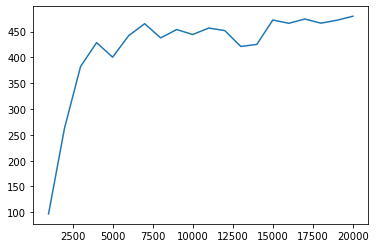

In [11]:
x = np.linspace(1000, 20000, 20)

plt.plot(x, np.array(all_reward)/1000)

## SARSA

In [12]:
env = gym.make('CartPole-v1')

Q = np.zeros([bins[0], bins[1], bins[2], bins[3], 2])
alpha = 0.1
gamma = 0.99
epsilon = 0.1

all_reward = []
epi_reward = 0

for i in range(1, 20001):
    state = env.reset()
    done = False
    
    ds = discretize_state(state, space_list)
    
    if random.uniform(0, 1) < epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[ds])
    
    tr = 0
    
    while not done:
        
        tr += 1
        
        next_state, reward, done, info = env.step(action)
        
        dns = discretize_state(next_state, space_list)
        
        if random.uniform(0, 1) < epsilon:
            next_action = env.action_space.sample()
        else:
            next_action = np.argmax(Q[dns])
        
        epi_reward += reward
        
        if done and tr < 300:
            reward = -500
        
        Q[ds][action] = (1 - alpha) * Q[ds][action] + alpha * (reward + gamma * Q[dns][next_action])
        
        state = next_state
        action = next_action
        ds = dns
        
    if i % 1000 == 0:
        clear_output(wait=True)
        print('Episode:', i)
        print('sum of reward', epi_reward)
        #test(Q)
        test2(Q)
        all_reward.append(epi_reward)
        epi_reward = 0
        
print('학습 완료')

Episode: 20000
sum of reward 429911.0
학습 완료


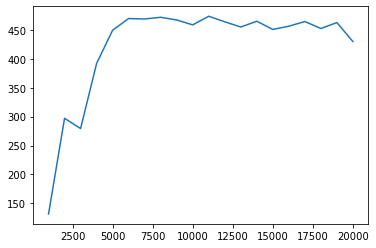

In [13]:
x = np.linspace(1000, 20000, 20)

plt.plot(x, np.array(all_reward)/1000)